https://www.linkedin.com/pulse/algorithmic-trading-mean-reversion-using-python-bryan-chen/

https://github.com/bryancwh/algo-trading-mean-reversion

## Algorithmic Trading: Mean Reversion 

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

In [233]:
df = yf.download("2330.TW", start="2010-01-01", end="2023-11-30")
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,65.000000,65.000000,64.000000,64.900002,41.498028,39407000
2010-01-05,65.000000,65.099998,63.900002,64.500000,41.242249,37138000
2010-01-06,64.500000,64.900002,63.700001,64.900002,41.498028,49261000
2010-01-07,64.900002,65.000000,64.199997,64.199997,41.050434,42134000
2010-01-08,63.500000,64.300003,63.500000,64.000000,40.922554,46076000
...,...,...,...,...,...,...
2023-11-23,574.000000,578.000000,574.000000,578.000000,578.000000,14486134
2023-11-24,577.000000,578.000000,574.000000,575.000000,575.000000,10058969
2023-11-27,573.000000,577.000000,568.000000,568.000000,568.000000,18528520


In [234]:
# #Data Cleaning
# # metadata = r['Meta Data']
# # df = pd.DataFrame(r['Time Series (Daily)'], dtype=float).transpose()

# #Reverse index
# df = df.reindex(index=df.index[::-1])
# df.reset_index(level=0, inplace=True)

# #Rename cols
# df = df.rename({
#     'index': 'date',
#     '1. open': 'open',
#     '2. high': 'high',
#     '3. low': 'low',
#     '4. close': 'close',
#     '5. adjusted close': 'adjusted_close',
#     '6. volume': 'volume',
#     '7. dividend amount': 'dividend_amount',
#     '8. split coefficient': 'split_coefficient'
# },axis=1)

# #Convert date col to datetime format
# df['date'] = pd.to_datetime(df['date'])

In [235]:
# df = df[((df['date'] >= pd.to_datetime('2019-01-01')) & (df['date'] <= pd.to_datetime('2021-06-01')))]

### Calculate ma

In [236]:
#Short moving averages (5-20 periods) are best suited for short-term trends and trading
df['ma_20'] = df['Close'].rolling(20).mean()

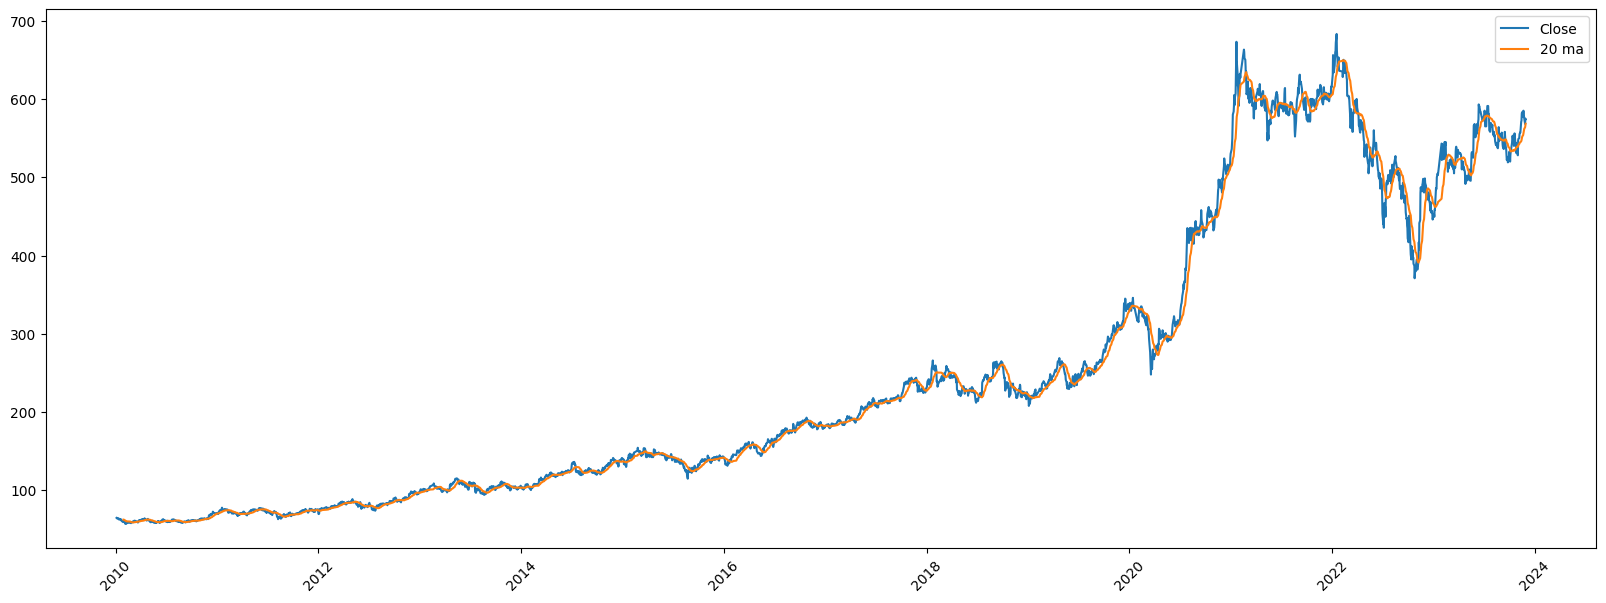

In [237]:
#plot for validation
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)

plt.plot(df.index, df['Close'], label = 'Close')
plt.plot(df.index, df['ma_20'], label = '20 ma')

plt.legend()
plt.show()

### Calculate Bollinger Bands

In [238]:
period = 20

#Calculate 20-ma and std dev
df['ma_20'] = df['Close'].rolling(period).mean()
df['std'] = df['Close'].rolling(period).std()

#Calculate bollinger bands using std dev
df['upper_bollinger'] = df['ma_20'] + (2 * df['std'])
df['lower_bollinger'] = df['ma_20'] - (2 * df['std'])

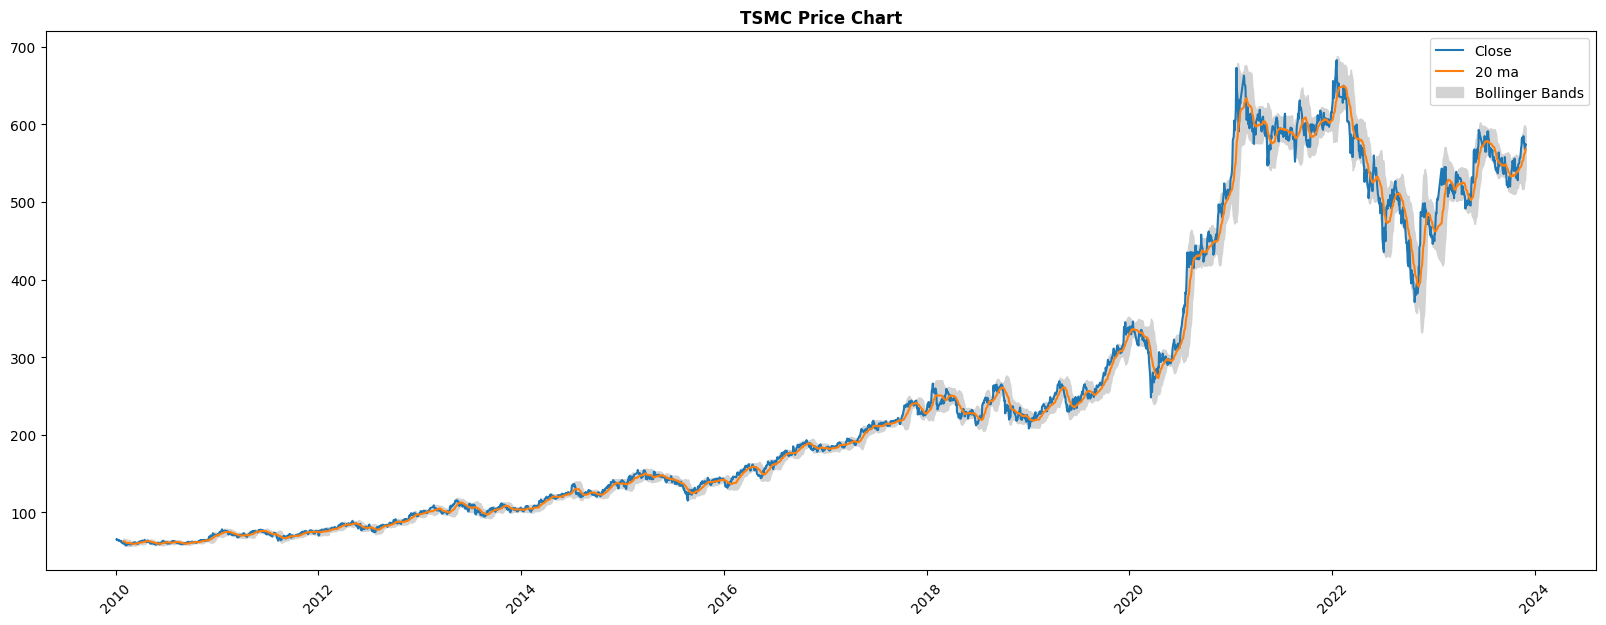

In [239]:
#plot for validation
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)

x_axis = df.index

plt.plot(x_axis, df['Close'], label = 'Close')
plt.plot(df.index, df['ma_20'], label = '20 ma')
plt.fill_between(x_axis, df['upper_bollinger'], df['lower_bollinger'], label = 'Bollinger Bands', color='lightgrey')

plt.title('TSMC Price Chart', fontweight="bold")
plt.legend()
plt.show()

### Calculate RSI

In [240]:
def gain(value):
    if value < 0:
        return 0
    else:
        return value

In [241]:
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)

In [242]:
period = 6

#Calculate price delta
df['delta'] = df['Close'].diff()

#Classify delta into gain & loss
df['gain'] = df['delta'].apply(lambda x:gain(x))
df['loss'] = df['delta'].apply(lambda x:loss(x))

#Calculate ema 
df['ema_gain'] = df['gain'].ewm(period).mean()
df['ema_loss'] = df['loss'].ewm(period).mean()

#Calculate RSI
df['rs'] = df['ema_gain']/df['ema_loss']
df['rsi'] = df['rs'].apply(lambda x: 100 - (100/(x+1)))

(0.0, 100.0)

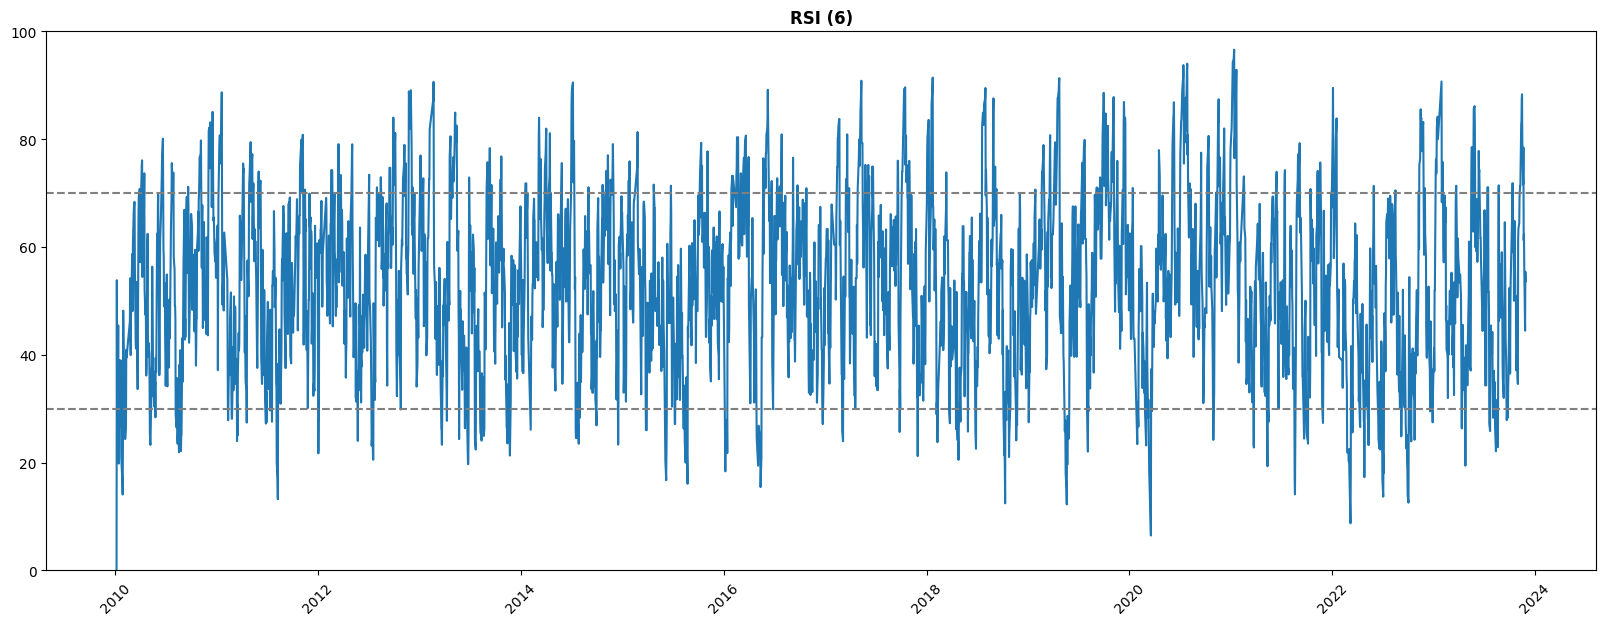

In [243]:
#plot for validation
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)

x_axis = df.index

plt.plot(x_axis, df['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')

plt.title('RSI (6)', fontweight="bold")
plt.ylim([0, 100])

### Implementing buy/sell

#### Rules:
    1. Buy when 10-period RSI below 30 (buy next day) & Price below lower bollinger band
    2. Sell when 10-period RSI above 70 (sell next day) & Price above upper bollinger band

In [244]:
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['Close'] < df['lower_bollinger']), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) & 
    (df['Close'] > df['upper_bollinger']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

### Backtesting Strategy

In [245]:
df

,Open,High,Low,Close,Adj Close,Volume,ma_20,std,upper_bollinger,lower_bollinger,delta,gain,loss,ema_gain,ema_loss,rs,rsi,signal
Date,,,,,,,,,,,,,,,,,,
2010-01-04,65.000000,65.000000,64.000000,64.900002,41.498028,39407000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2010-01-05,65.000000,65.099998,63.900002,64.500000,41.242249,37138000,NaN,NaN,NaN,NaN,-0.400002,0.000000,0.400002,0.000000,0.400002,0.000000,0.000000,0.0
2010-01-06,64.500000,64.900002,63.700001,64.900002,41.498028,49261000,NaN,NaN,NaN,NaN,0.400002,0.400002,0.000000,0.215385,0.184616,1.166667,53.846154,0.0
2010-01-07,64.900002,65.000000,64.199997,64.199997,41.050434,42134000,NaN,NaN,NaN,NaN,-0.700005,0.000000,0.700005,0.132284,0.383467,0.344969,25.648818,0.0
2010-01-08,63.500000,64.300003,63.500000,64.000000,40.922554,46076000,NaN,NaN,NaN,NaN,-0.199997,0.000000,0.199997,0.091222,0.326516,0.279380,21.837124,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-23,574.000000,578.000000,574.000000,578.000000,578.000000,14486134,559.85,19.342549,598.535098,521.164902,1.000000,1.000000,0.000000,2.878402,1.731074,1.662784,62.445320,0.0
2023-11-24,577.000000,578.000000,574.000000,575.000000,575.000000,10058969,561.95,18.537231,599.024463,524.875537,-3.000000,0.000000,3.000000,2.467202,1.912349,1.290142,56.334583,0.0
2023-11-27,573.000000,577.000000,568.000000,568.000000,568.000000,18528520,563.75,17.173649,598.097297,529.402703,-7.000000,0.000000,7.000000,2.114744,2.639156,0.801296,44.484402,0.0


In [255]:
def backtest_dataframe(df):
    position = 0
    net_profit = 0
    percentage_change = []
    df['buy_date'] = ''
    df['sell_date'] = ''

    for i in range(len(df)):
        close = df['Close'].iloc[i]
        date = df.index[i]

        # Buy action
        if df["signal"].iloc[i] == 1:
            if (position == 0):
                buy_price = close
                position = 1
                df.at[i, 'buy_date'] = date
                # print(f"Buying at {str(buy_price)} on {str(date)}")

        # Sell action
        elif (df["signal"].iloc[i] == -1):
            if(position == 1):
                sell_price = close
                bought = 0
                position = 0
                df.at[i, 'sell_date'] = date
                # print(f"Selling at {str(sell_price)} on {str(date)}")

                # Get percentage change of trade
                pc = (sell_price/buy_price-1)*100
                percentage_change.append(pc)
                net_profit += (sell_price - buy_price)

    # Calculate trade statistics
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1

    for i in percentage_change:
        if(i > 0):
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i/100)+1)

    totalR = round((totalR-1)*100, 2)

    if(ng > 0):
        avgGain = round(gains/ng, 2)
        maxR = round(max(percentage_change), 2)
    else:
        avgGain = 0
        maxR = "undefined"

    if(nl > 0):
        avgLoss = round(losses/nl, 2)
        maxL = round(min(percentage_change), 2)
    else:
        avgLoss = 0
        maxL = "undefined"

    if(ng > 0 or nl > 0):
        win_rate = round((ng/(ng+nl))*100, 2)
    else:
        win_rate = 0

    print()
    print('Evaluation Metrics:')
    print('-----------------------------------')
    # print(f"Number of Trades: {ng+nl}")
    # print(f"Number of Gains: {ng}")
    # print(f"Number of Losses: {nl}")
    print(f"Total Returns: {totalR}%")
    print(f"Win Rate: {win_rate}%")
    print(f"Average Gain: {avgGain}%")
    print(f"Average Loss: {avgLoss}%")
    print(f"Max Return: {maxR}%")
    print(f"Max Loss: {maxL}%")
    print()

In [256]:
backtest_dataframe(df)

[10.62717475951791, 5.378152542755377, 0.4137973127694039, 1.5172392746497954, 13.475177304964546, 0.7444149943920175, 14.11609039241859, 9.92908141314015, -3.7735849056603765, 3.864734299516903, 14.448669201520904, -1.7857142857142905, 8.270676691729317, 6.440677966101704, 4.418604651162794, 3.6796536796536827, 1.2605042016806678, -2.8747433264887046, 3.0181086519114775, -5.000000000000004, 6.78260869565217, 18.840579710144922, -9.10596026490066, -7.386363636363635, 10.02178649237473, 7.833163784333674, 8.952380952380956]

Evaluation Metrics:
-----------------------------------
Total Returns: 217.48%
Win Rate: 77.78%
Average Gain: 7.33%
Average Loss: -4.99%
Max Return: 18.84%
Max Loss: -9.11%



In [252]:
df['signal'].value_counts()

signal
 0.0    3111
-1.0     198
 1.0      98
Name: count, dtype: int64

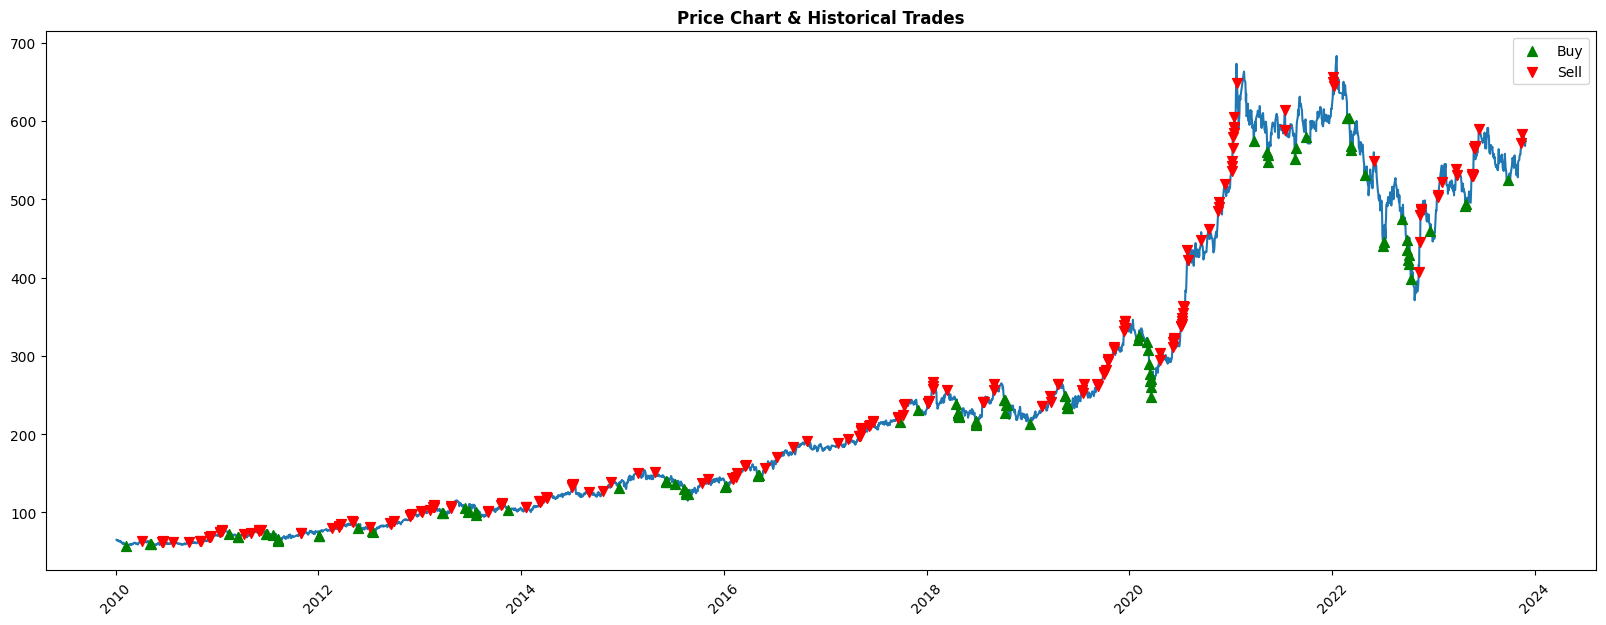

In [253]:
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)

plt.plot(df.index, df['Close'])
plt.scatter(x=df[(df['signal'] == 1)].index, y=df[(df['signal'] == 1)]['Close'], label = 'Buy', marker='^', s=50, c='g', zorder=3)
plt.scatter(df[(df['signal'] == -1)].index, df[(df['signal'] == -1)]['Close'], label = 'Sell', marker='v', s=50, c='r', zorder=3)

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()

In [228]:
from statistics import mean 

def backtest_dataframe(df):
    long_position = 0
    short_position = 0
    net_profit = 0
    percentage_change = []
    df['buy_date'] = ''
    df['sell_date'] = ''
    buy_price_lst = []
    sell_price_lst = []

    for i in range(len(df)):
        close = df['Close'].iloc[i]
        date = df.index[i]

        # Buy action
        if df["signal"].iloc[i] == 1:
            if short_position != 0:
                buy_price = close
                pc = (buy_price/avg_sell_price-1)*100
                percentage_change.append(pc)
                net_profit += (buy_price - avg_sell_price)*short_position

                long_position += 1
                short_position = 0
                df.at[i, 'buy_date'] = date
                sell_price_lst = []
                buy_price_lst.append(close)
                avg_buy_price = mean(buy_price_lst)
            else:
                buy_price_lst.append(close)
                avg_buy_price = mean(buy_price_lst)
                long_position += 1
                short_position = 0
                df.at[i, 'buy_date'] = date
                # print(f"Buying at {str(buy_price)} on {str(date)}")

        # Sell action
        elif (df["signal"].iloc[i] == -1):
            if long_position != 0:
                sell_price = close
                pc = (sell_price/avg_buy_price-1)*100
                percentage_change.append(pc)
                net_profit += (sell_price - avg_buy_price)*long_position
                
                short_position += 1
                long_position = 0
                df.at[i, 'sell_date'] = date
                buy_price_lst = []
                sell_price_lst.append(close)
                avg_sell_price = mean(sell_price_lst)
            else:
                sell_price_lst.append(close)
                avg_sell_price = mean(sell_price_lst)
                short_position += 1
                long_position = 0
                df.at[i, 'sell_date'] = date
                # print(f"Selling at {str(sell_price)} on {str(date)}")

    # Calculate trade statistics
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1

    for i in percentage_change:
        if(i > 0):
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i/100)+1)

    totalR = round((totalR-1)*100, 2)

    if(ng > 0):
        avgGain = round(gains/ng, 2)
        maxR = round(max(percentage_change), 2)
    else:
        avgGain = 0
        maxR = "undefined"

    if(nl > 0):
        avgLoss = round(losses/nl, 2)
        maxL = round(min(percentage_change), 2)
    else:
        avgLoss = 0
        maxL = "undefined"

    if(ng > 0 or nl > 0):
        win_rate = round((ng/(ng+nl))*100, 2)
    else:
        win_rate = 0

    print()
    print('Evaluation Metrics:')
    print('-----------------------------------')
    # print(f"Number of Trades: {ng+nl}")
    # print(f"Number of Gains: {ng}")
    # print(f"Number of Losses: {nl}")
    print(f"Total Returns: {totalR}%")
    print(f"Win Rate: {win_rate}%")
    print(f"Average Gain: {avgGain}%")
    print(f"Average Loss: {avgLoss}%")
    print(f"Max Return: {maxR}%")
    print(f"Max Loss: {maxL}%")
    print()

In [229]:
backtest_dataframe(df)


Evaluation Metrics:
-----------------------------------
Total Returns: 219.3%
Win Rate: 58.49%
Average Gain: 7.89%
Average Loss: -5.01%
Max Return: 30.54%
Max Loss: -19.85%



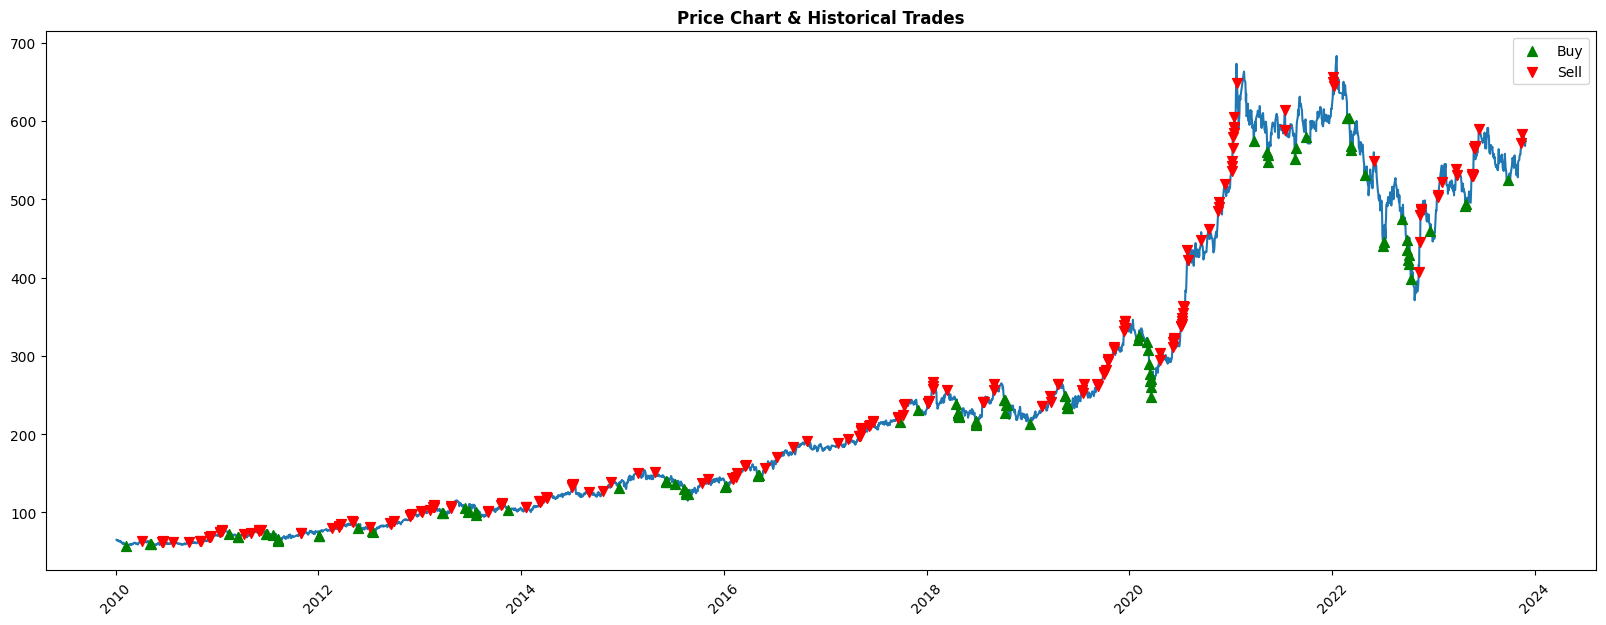

In [230]:
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)

plt.plot(df.index, df['Close'])
plt.scatter(x=df[(df['signal'] == 1)].index, y=df[(df['signal'] == 1)]['Close'], label = 'Buy', marker='^', s=50, c='g', zorder=3)
plt.scatter(df[(df['signal'] == -1)].index, df[(df['signal'] == -1)]['Close'], label = 'Sell', marker='v', s=50, c='r', zorder=3)

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()